In [3]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Leer el archivo JSON
with open("TelecomX_Data.json", encoding="utf-8") as f:
    data = json.load(f)

# Si el JSON tiene una estructura tipo {"data": [...]}, descomenta la línea siguiente:
# data = data["data"]

# Convertir a DataFrame
df = pd.DataFrame(data)

# Mostrar dimensiones y primeras filas
print("Filas y columnas:", df.shape)
df.head()


Filas y columnas: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


 Iniciar limpieza y transformación

In [8]:
# Expandir columnas anidadas
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Combinar todo con columnas principales
df_flat = pd.concat([
    df[['customerID', 'Churn']],
    df_customer,
    df_phone,
    df_internet,
    df_account
], axis=1)

# Mostrar estructura final
print("Shape final:", df_flat.shape)
df_flat.head()


Shape final: (7267, 14)


,customerID,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [9]:
# Convertir columnas binarias
columnas_binarias = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                     'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

for col in columnas_binarias:
    if col in df_flat.columns:
        df_flat[col] = df_flat[col].map({'Yes': 1, 'No': 0})

# Convertir 'Churn'
df_flat['Churn'] = df_flat['Churn'].map({'Yes': 1, 'No': 0})

# Verificar nulos
df_flat.isna().sum()


,0
customerID,0
Churn,224
InternetService,0
OnlineSecurity,1581
OnlineBackup,1581
DeviceProtection,1581
TechSupport,1581
StreamingTV,1581
StreamingMovies,1581
Contract,0


In [10]:
df_flat.to_csv("telecomx_limpio.csv", index=False)

from google.colab import files
files.download("telecomx_limpio.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

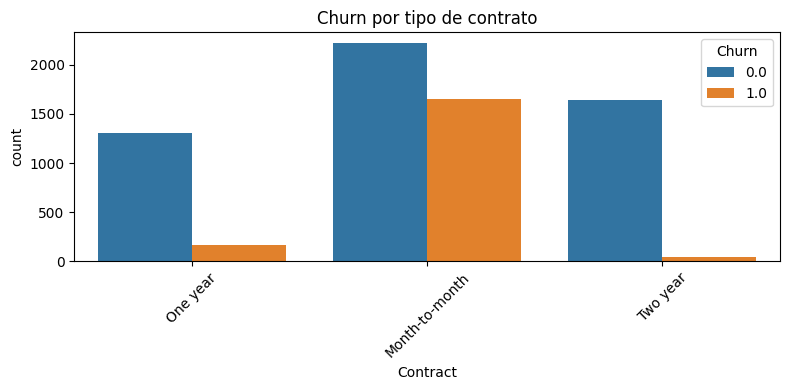

In [11]:
# Gráfico de Churn por tipo de contrato
plt.figure(figsize=(8,4))
sns.countplot(data=df_flat, x='Contract', hue='Churn')
plt.title('Churn por tipo de contrato')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

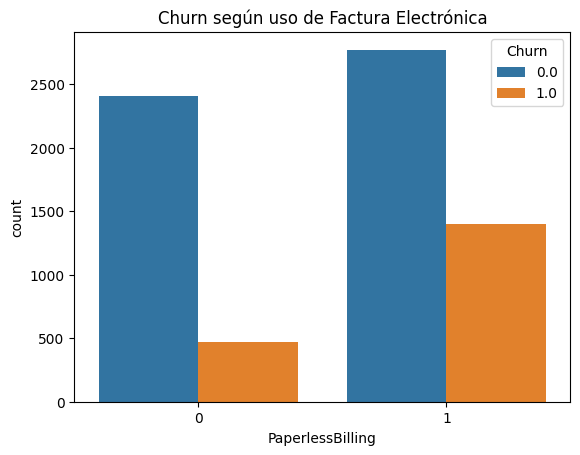

In [12]:
# Distribución de clientes con y sin PaperlessBilling
sns.countplot(data=df_flat, x='PaperlessBilling', hue='Churn')
plt.title("Churn según uso de Factura Electrónica")
plt.show()

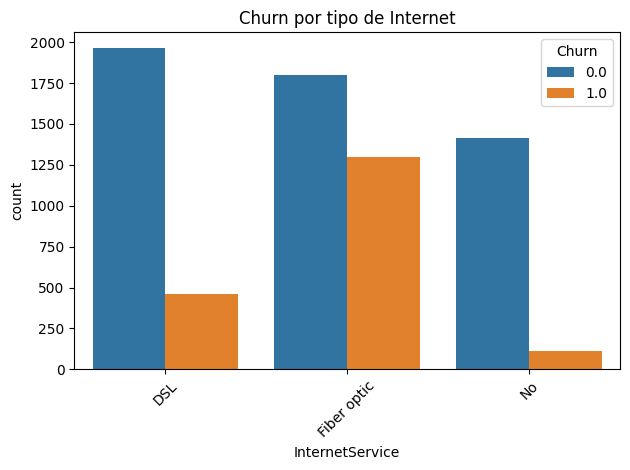

In [14]:
sns.countplot(data=df_flat, x='InternetService', hue='Churn')
plt.title("Churn por tipo de Internet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

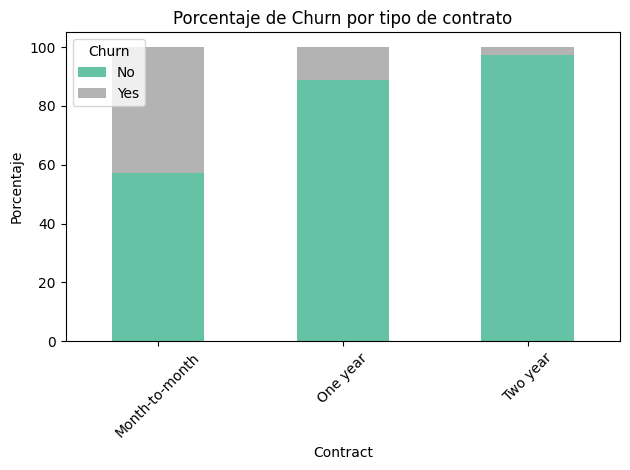

In [15]:
contract_churn = pd.crosstab(df_flat['Contract'], df_flat['Churn'], normalize='index') * 100
contract_churn.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Porcentaje de Churn por tipo de contrato")
plt.ylabel("Porcentaje")
plt.legend(title="Churn", labels=["No", "Yes"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

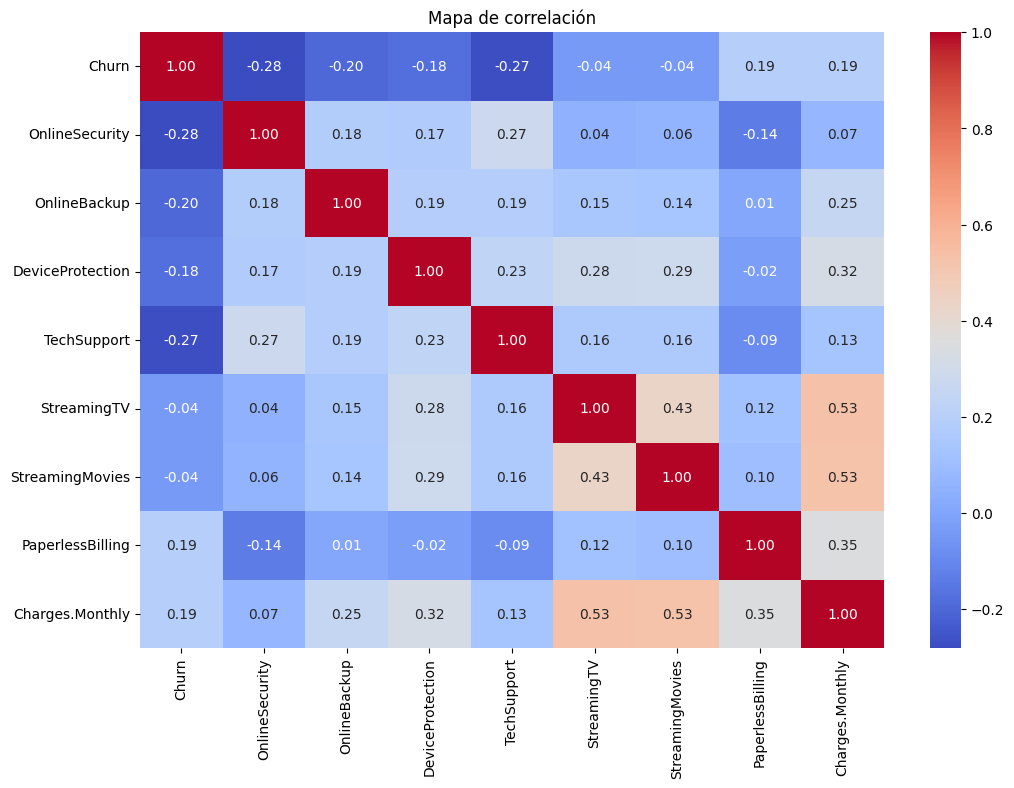

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df_flat.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de correlación")
plt.show()